In [159]:
%reload_ext autoreload
%autoreload 2

In [160]:
import h5py
data_path = '/auto/brno12-cerit/nfs4/home/tslaninakova/sisap-challenge/data/pca32v2/100K/dataset.h5'
%time f = h5py.File(data_path, 'r')

CPU times: user 881 µs, sys: 108 µs, total: 989 µs
Wall time: 2.58 ms


In [161]:
%time loaded_data = f['pca32'][:, :]

CPU times: user 0 ns, sys: 7.97 ms, total: 7.97 ms
Wall time: 7.98 ms


In [162]:
import pandas as pd
data = pd.DataFrame(loaded_data)
data.index += 1
#data_s = data.sample(5_000_000, random_state=2023)

In [163]:
%%time
gt_path = f'/auto/brno12-cerit/nfs4/home/tslaninakova/sisap-challenge/data/groundtruth-100K.h5'
f3 = h5py.File(gt_path, 'r')
loaded_gt = f3['knns'][:, :]

CPU times: user 0 ns, sys: 3.86 ms, total: 3.86 ms
Wall time: 4.66 ms


In [164]:
from li.BaseLMI import cluster_kmeans_faiss

In [165]:
_, basic_clustering = cluster_kmeans_faiss(data, n_clusters=10)

In [166]:
basic_clustering.shape

(100000,)

In [167]:
data['category'] = basic_clustering

In [168]:
from li.model import NeuralNetwork, data_X_to_torch, data_to_torch

In [169]:
loaded_data.shape

(100000, 32)

In [170]:
nn = NeuralNetwork(input_dim=32, output_dim=10)

In [171]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s][%(levelname)-5.5s][%(name)-.20s] %(message)s'
)
LOG = logging.getLogger(__name__)

In [172]:
data_x, data_y = data_to_torch(loaded_data, basic_clustering)
%time losses = nn.train(data_x, data_y, epochs=1000, logger=LOG)

[2023-07-03 14:50:49,535][INFO ][__main__] Epochs: 1000, step: 100
[2023-07-03 14:51:25,159][INFO ][__main__] Epoch 100 | Loss 0.02519792504608631
[2023-07-03 14:52:21,782][INFO ][__main__] Epoch 200 | Loss 0.019894858822226524
[2023-07-03 14:53:24,079][INFO ][__main__] Epoch 300 | Loss 0.014030814170837402
[2023-07-03 14:54:24,626][INFO ][__main__] Epoch 400 | Loss 0.00879271887242794
[2023-07-03 14:55:25,084][INFO ][__main__] Epoch 500 | Loss 0.006988594774156809
[2023-07-03 14:56:23,152][INFO ][__main__] Epoch 600 | Loss 0.005604397971183062
[2023-07-03 14:57:19,718][INFO ][__main__] Epoch 700 | Loss 0.004538560286164284
[2023-07-03 14:58:13,027][INFO ][__main__] Epoch 800 | Loss 0.0037040801253169775
[2023-07-03 14:59:05,355][INFO ][__main__] Epoch 900 | Loss 0.00305874808691442


CPU times: user 7min 27s, sys: 1min 16s, total: 8min 44s
Wall time: 9min 7s


In [173]:
#/auto/brno12-cerit/nfs4/home/tslaninakova/sisap-challenge/data/pca32v2/100K/query.h5
import h5py
query_path = '/auto/brno12-cerit/nfs4/home/tslaninakova/sisap-challenge/data/pca32v2/100K/query.h5'
%time f = h5py.File(query_path, 'r')
%time loaded_queries = f['pca32'][:, :]

CPU times: user 1.83 ms, sys: 259 µs, total: 2.08 ms
Wall time: 8.56 ms
CPU times: user 0 ns, sys: 3.48 ms, total: 3.48 ms
Wall time: 16.6 ms


In [19]:
loaded_queries.shape

(10000, 32)

In [181]:
res = nn.predict_proba(data_X_to_torch(loaded_queries))

In [182]:
res[0][0]

array([1.0000000e+00, 2.8025969e-45, 6.5373376e-41, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.3325643e-38,
       0.0000000e+00, 3.0982036e-35], dtype=float32)

<AxesSubplot:>

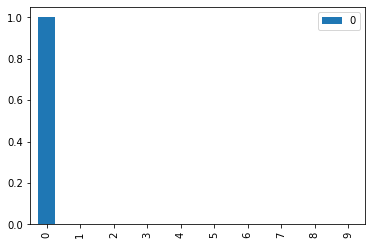

In [183]:
pd.DataFrame(res[0][0]).plot.bar()

In [174]:
import numpy as np
from tqdm import tqdm

In [194]:
data.loc[loaded_gt[0][:10]].category

79172    0
15735    0
22337    0
231      0
74173    0
41079    0
38159    0
71849    0
69015    0
92811    0
Name: category, dtype: int64

In [195]:
np.argmax(res[0][0])

0

In [191]:
np.argsort(res[0][0])[::-1]

array([0, 9, 7, 2, 1, 8, 6, 5, 4, 3])

In [185]:
np.sum(data.loc[loaded_gt[0][:10]].category == np.argmax(res[0][0]))

10

In [ ]:
    correct_cat_perc.append(
        np.sum(data.loc[loaded_gt[i][:10]].category == np.argmax(res[0][i]))
    )

In [205]:
for j in np.argsort(res[0][i])[::-1]:
    print(j)
    print(res[0][i][j])

0
1.0
9
3.0982036e-35
7
4.3325643e-38
2
6.5373e-41
1
3e-45
8
0.0
6
0.0
5
0.0
4
0.0
3
0.0


In [204]:
j

3

In [202]:
res[0][i][j]

1.0

In [197]:
data.loc[loaded_gt[i][:10]].category

79172    0
15735    0
22337    0
231      0
74173    0
41079    0
38159    0
71849    0
69015    0
92811    0
Name: category, dtype: int64

In [210]:
data.query('category == 0').shape[0]

17098

In [216]:
np.sum(basic_clustering == 0)

17098

In [ ]:
n_cats_covered = []
n_objects_covered = []

for i in tqdm(range(10_000)):
    overall_sum = 0
    overall_objects_sum = 0
    argsorted = np.argsort(res[0][i])[::-1]
    idx = 0
    while overall_sum < 9:
        overall_sum += np.sum(data.loc[loaded_gt[i][:10]].category == argsorted[idx])
        overall_objects_sum += np.sum(basic_clustering == argsorted[idx])
        idx += 1
    n_cats_covered.append(idx)
    n_objects_covered.append(overall_objects_sum)

In [188]:
correct_cat_perc[:10]

[10, 10, 10, 10, 2, 0, 8, 10, 2, 8]

In [218]:
np.mean(np.array(n_cats_covered))

2.2811

In [219]:
np.mean(np.array(n_objects_covered))

25176.2491

### vs. random pivots

In [114]:
rng = np.random.default_rng(seed=2023)
pivot_indexes = rng.choice(range(100_000), size=(10), replace=False)
pivot_indexes.shape, pivot_indexes[:10]

((10,),
 array([22042, 69733, 25528, 59967, 44295,  8804, 11316, 15732, 29828,
        47322]))

In [115]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,category
1,0.142266,0.121459,-0.054467,-0.058987,0.049365,-0.107044,0.123232,0.003732,0.044797,-0.118452,...,0.037666,-0.089511,0.077113,-0.118540,0.058264,0.065489,0.028578,-0.089683,0.126804,5
2,0.213798,-0.011502,-0.015170,0.149934,0.106344,0.082373,-0.120631,-0.061052,0.068679,0.033809,...,-0.013627,0.004503,-0.046667,-0.043632,-0.086331,-0.011793,-0.047739,0.020949,-0.030398,6
3,0.069708,-0.213904,0.132880,-0.150276,-0.049206,0.080040,-0.023638,0.017214,-0.208746,0.053342,...,0.023209,-0.048399,-0.051265,0.019088,-0.036999,0.006381,0.011267,-0.029590,0.076341,0
4,0.136409,-0.124815,-0.154166,0.239908,0.002291,0.145442,-0.069386,-0.006642,0.124328,0.054876,...,0.027433,0.072961,-0.035555,-0.003668,-0.007776,-0.065730,-0.013595,-0.012795,-0.030780,6
5,-0.389241,0.076076,-0.072001,0.103547,-0.058551,0.033468,0.017906,0.094761,0.034065,-0.220189,...,-0.016713,0.018730,0.050222,-0.021090,0.004709,0.043465,-0.049461,-0.052292,0.027773,9


In [116]:
pivot_data = data.drop(['category'], axis=1).sample(10, random_state=2023)

In [117]:
random_10k_data = data.drop(['category'], axis=1).sample(10_000, random_state=2023+1)

In [118]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time

def pairwise_cosine(x, y):
    return 1-cosine_similarity(x, y)

In [119]:
%time res = pairwise_cosine(pivot_data, data.drop(['category'], axis=1))

CPU times: user 30 ms, sys: 3.68 ms, total: 33.7 ms
Wall time: 33.7 ms


In [120]:
sorted_res = np.argsort(res)

In [121]:
sorted_res[0]

array([65740, 94976, 65224, ..., 69754, 30783, 30103])

In [122]:
sorted_res[0].shape

(100000,)

In [123]:
data['category_dists'] = np.NaN

In [124]:
for i in range(10):
    data.loc[sorted_res[i, :1000], 'category_dists'] = i

In [125]:
nn2 = NeuralNetwork(input_dim=32, output_dim=10, lr=1)

In [126]:
data_x, data_y = data_to_torch(
    data[~data.category_dists.isna()].drop(['category', 'category_dists'], axis=1),
    data[~data.category_dists.isna()].category_dists.values
)
%time losses = nn2.train(data_x, data_y, epochs=1000, logger=LOG)

[2023-07-03 12:47:52,551][INFO ][__main__] Epochs: 1000, step: 100
[2023-07-03 12:47:54,786][INFO ][__main__] Epoch 100 | Loss 2.292569637298584
[2023-07-03 12:47:56,775][INFO ][__main__] Epoch 200 | Loss 2.2867918014526367
[2023-07-03 12:47:58,763][INFO ][__main__] Epoch 300 | Loss 2.278618335723877
[2023-07-03 12:48:00,986][INFO ][__main__] Epoch 400 | Loss 2.271494150161743
[2023-07-03 12:48:03,550][INFO ][__main__] Epoch 500 | Loss 2.2627475261688232
[2023-07-03 12:48:05,592][INFO ][__main__] Epoch 600 | Loss 2.252671003341675
[2023-07-03 12:48:07,789][INFO ][__main__] Epoch 700 | Loss 2.246417760848999
[2023-07-03 12:48:10,044][INFO ][__main__] Epoch 800 | Loss 2.243048906326294
[2023-07-03 12:48:12,286][INFO ][__main__] Epoch 900 | Loss 2.239333391189575


CPU times: user 21.1 s, sys: 85.5 ms, total: 21.2 s
Wall time: 22 s


In [ ]:
## loss is much higher and goes down much more slowly than in the case of K-Means

In [127]:
predicted_cats = nn2.predict(data_X_to_torch(
    data[data.category_dists.isna()].drop(['category', 'category_dists'], axis=1)
))
predicted_cats.shape

(90313,)

In [128]:
data.loc[data.category_dists.isna()]

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,category,category_dists
1,0.142266,0.121459,-0.054467,-0.058987,0.049365,-0.107044,0.123232,0.003732,0.044797,-0.118452,...,-0.089511,0.077113,-0.118540,0.058264,0.065489,0.028578,-0.089683,0.126804,5,NaN
2,0.213798,-0.011502,-0.015170,0.149934,0.106344,0.082373,-0.120631,-0.061052,0.068679,0.033809,...,0.004503,-0.046667,-0.043632,-0.086331,-0.011793,-0.047739,0.020949,-0.030398,6,NaN
3,0.069708,-0.213904,0.132880,-0.150276,-0.049206,0.080040,-0.023638,0.017214,-0.208746,0.053342,...,-0.048399,-0.051265,0.019088,-0.036999,0.006381,0.011267,-0.029590,0.076341,0,NaN
4,0.136409,-0.124815,-0.154166,0.239908,0.002291,0.145442,-0.069386,-0.006642,0.124328,0.054876,...,0.072961,-0.035555,-0.003668,-0.007776,-0.065730,-0.013595,-0.012795,-0.030780,6,NaN
5,-0.389241,0.076076,-0.072001,0.103547,-0.058551,0.033468,0.017906,0.094761,0.034065,-0.220189,...,0.018730,0.050222,-0.021090,0.004709,0.043465,-0.049461,-0.052292,0.027773,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,-0.065555,-0.110774,0.027780,-0.022638,0.138626,-0.203276,-0.084971,-0.016191,-0.131503,-0.091344,...,-0.005175,-0.079819,0.045780,-0.010756,0.101217,0.052928,-0.029409,0.007089,7,NaN
99994,-0.016580,-0.047094,0.048885,0.053823,0.040815,0.164864,-0.087997,-0.173120,-0.062028,0.029086,...,0.014112,0.022947,0.032596,0.018570,-0.003964,0.054604,0.055929,0.031519,8,NaN
99995,-0.089185,-0.039447,0.142751,0.018894,-0.136014,-0.175853,-0.094182,-0.126959,0.107840,0.047235,...,0.019951,0.052902,-0.002340,-0.008083,-0.039704,-0.059032,-0.037460,-0.081697,2,NaN
99997,-0.225225,-0.004567,-0.004400,-0.034974,-0.129672,0.113504,-0.003353,-0.057222,0.090702,-0.004591,...,-0.041191,0.046411,0.003835,0.022965,0.112995,0.092276,0.041511,-0.017332,9,NaN


In [129]:
data.loc[data.category_dists.isna(), 'category_dists'] = predicted_cats

In [130]:
res = nn2.predict_proba(data_X_to_torch(loaded_queries))

In [131]:
res = nn2.predict_proba(data_X_to_torch(loaded_queries))
correct_cat_perc = []
for i in tqdm(range(10_000)):
    correct_cat_perc.append(
        np.sum(data.loc[loaded_gt[i][:10]].category == np.argmax(res[0][i]))
    )
np.mean(np.array(correct_cat_perc))

100%|██████████| 10000/10000 [00:09<00:00, 1052.74it/s]


In [132]:
np.mean(np.array(correct_cat_perc))

0.4445

In [ ]:
### mem-friendly kmedoids

In [133]:
from li.BaseLMI import cluster_kmedoids

In [134]:
data.drop(['category', 'category_dists'], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
1,0.142266,0.121459,-0.054467,-0.058987,0.049365,-0.107044,0.123232,0.003732,0.044797,-0.118452,...,0.063983,0.037666,-0.089511,0.077113,-0.118540,0.058264,0.065489,0.028578,-0.089683,0.126804
2,0.213798,-0.011502,-0.015170,0.149934,0.106344,0.082373,-0.120631,-0.061052,0.068679,0.033809,...,-0.098288,-0.013627,0.004503,-0.046667,-0.043632,-0.086331,-0.011793,-0.047739,0.020949,-0.030398
3,0.069708,-0.213904,0.132880,-0.150276,-0.049206,0.080040,-0.023638,0.017214,-0.208746,0.053342,...,0.035558,0.023209,-0.048399,-0.051265,0.019088,-0.036999,0.006381,0.011267,-0.029590,0.076341
4,0.136409,-0.124815,-0.154166,0.239908,0.002291,0.145442,-0.069386,-0.006642,0.124328,0.054876,...,-0.045160,0.027433,0.072961,-0.035555,-0.003668,-0.007776,-0.065730,-0.013595,-0.012795,-0.030780
5,-0.389241,0.076076,-0.072001,0.103547,-0.058551,0.033468,0.017906,0.094761,0.034065,-0.220189,...,-0.051880,-0.016713,0.018730,0.050222,-0.021090,0.004709,0.043465,-0.049461,-0.052292,0.027773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,0.126578,0.028599,-0.042934,0.001947,-0.202029,-0.128166,0.154031,0.023840,-0.009978,-0.046443,...,0.012223,0.061135,-0.004755,-0.051334,-0.058041,-0.034305,-0.015373,0.018450,-0.048168,0.030826
99997,-0.225225,-0.004567,-0.004400,-0.034974,-0.129672,0.113504,-0.003353,-0.057222,0.090702,-0.004591,...,0.034556,-0.015325,-0.041191,0.046411,0.003835,0.022965,0.112995,0.092276,0.041511,-0.017332
99998,0.101137,0.037512,-0.051941,0.231012,0.011707,0.103784,0.142680,-0.054836,-0.078768,-0.032020,...,0.027843,-0.110345,0.009569,-0.062856,0.009437,-0.065775,0.065454,0.017647,-0.066954,-0.031620
99999,-0.271447,0.021036,-0.050439,0.088891,-0.086671,-0.157237,0.029204,-0.001032,-0.122273,-0.076587,...,0.013939,-0.248462,0.068649,-0.014509,0.040324,-0.038653,-0.043279,0.056283,-0.011639,-0.088651


In [138]:
data['category_kmedoids_L0'] = np.nan
data['category_kmedoids_L1'] = np.nan

In [ ]:
        data.drop(
            [c for c in data.columns if type(c) is not int and c.startswith('category')],
            axis=1
        ).sample(1000, random_state=2023).index,

In [147]:
for i in range(10):
    data.loc[
        data.sample(1000, random_state=2023+i).index,
        'category_kmedoids_L0'
    ] = i

In [143]:
%%time
for i in tqdm(range(10)):
    sample_data = data.drop(
        [c for c in data.columns if type(c) is not int and c.startswith('category')],
        axis=1
    ).sample(1000, random_state=2023+i)
    res = cluster_kmedoids(
        sample_data,
        n_clusters=10
    )
    data.loc[
        sample_data.index,
        'category_kmedoids_L1'
    ] = res

100%|██████████| 10/10 [04:36<00:00, 25.85s/it]

CPU times: user 3min 56s, sys: 37.5 s, total: 4min 33s
Wall time: 4min 36s


In [144]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,category,category_dists,category_kmedoids,category_kmedoids_L0,category_kmedoids_L1
1,0.142266,0.121459,-0.054467,-0.058987,0.049365,-0.107044,0.123232,0.003732,0.044797,-0.118452,...,0.058264,0.065489,0.028578,-0.089683,0.126804,5,3.0,NaN,NaN,NaN
2,0.213798,-0.011502,-0.015170,0.149934,0.106344,0.082373,-0.120631,-0.061052,0.068679,0.033809,...,-0.086331,-0.011793,-0.047739,0.020949,-0.030398,6,3.0,NaN,NaN,NaN
3,0.069708,-0.213904,0.132880,-0.150276,-0.049206,0.080040,-0.023638,0.017214,-0.208746,0.053342,...,-0.036999,0.006381,0.011267,-0.029590,0.076341,0,3.0,NaN,NaN,NaN
4,0.136409,-0.124815,-0.154166,0.239908,0.002291,0.145442,-0.069386,-0.006642,0.124328,0.054876,...,-0.007776,-0.065730,-0.013595,-0.012795,-0.030780,6,3.0,NaN,NaN,NaN
5,-0.389241,0.076076,-0.072001,0.103547,-0.058551,0.033468,0.017906,0.094761,0.034065,-0.220189,...,0.004709,0.043465,-0.049461,-0.052292,0.027773,9,3.0,NaN,NaN,NaN


In [148]:
data[~data.category_kmedoids_L0.isna()]

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,category,category_dists,category_kmedoids,category_kmedoids_L0,category_kmedoids_L1
52,0.083822,0.224769,0.006545,0.013659,0.021017,0.149854,-0.141947,0.032536,-0.045944,-0.002056,...,-0.061882,-0.063450,0.023306,0.091412,0.031021,8,3.0,NaN,3.0,0.0
76,-0.017333,-0.030346,0.070804,0.189865,-0.224266,-0.201467,0.039872,0.005959,0.017323,0.127923,...,-0.071525,-0.018568,-0.006807,0.001746,0.020482,2,3.0,NaN,9.0,7.0
83,0.139110,0.208291,0.090843,-0.072079,-0.153821,-0.190293,-0.065602,0.014934,0.008904,-0.130615,...,-0.004722,0.025246,-0.027618,-0.012081,-0.035570,4,6.0,NaN,2.0,3.0
101,0.272022,0.253499,0.049000,0.150345,-0.096239,-0.011524,0.037366,0.048216,0.074086,-0.011571,...,-0.022141,-0.053233,0.012195,-0.000026,0.033662,4,4.0,NaN,6.0,1.0
108,-0.074508,0.164031,0.067475,-0.157874,-0.015268,0.073878,-0.066657,-0.067742,0.011106,-0.040924,...,0.047263,0.038121,-0.015616,0.047262,-0.062203,5,3.0,NaN,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99915,-0.024555,-0.104217,0.094191,0.004916,-0.185176,-0.200365,-0.063207,0.004634,0.014108,0.018544,...,-0.001410,-0.076884,0.083940,-0.024870,-0.013091,2,3.0,NaN,6.0,9.0
99966,0.004975,0.012663,0.033989,0.065087,-0.026223,0.125094,-0.052018,-0.030596,-0.049951,-0.083827,...,0.031660,-0.005630,0.022570,0.007909,0.033589,8,3.0,NaN,1.0,2.0
99971,0.150639,0.228047,-0.227044,0.093524,0.120780,0.018932,-0.112216,0.166368,0.124071,0.078234,...,0.038655,0.036180,-0.051192,-0.035509,0.011690,6,3.0,NaN,1.0,1.0
99986,-0.135976,-0.052845,0.086699,-0.122668,-0.009197,0.146849,-0.024676,0.046907,-0.010380,0.137580,...,0.038401,-0.013552,0.031110,0.031184,-0.114517,1,3.0,NaN,0.0,2.0


In [151]:
nn3 = NeuralNetwork(input_dim=32, output_dim=10, lr=0.1)

In [153]:
data_x, data_y = data_to_torch(
    data[~data.category_kmedoids_L0.isna()].drop(
        [c for c in data.columns if type(c) is not int and c.startswith('category')],
        axis=1
    ),
    data[~data.category_kmedoids_L0.isna()].category_kmedoids_L0.values
)
%time losses = nn3.train(data_x, data_y, epochs=5000, logger=LOG)

[2023-07-03 13:08:45,383][INFO ][__main__] Epochs: 5000, step: 500
[2023-07-03 13:08:56,505][INFO ][__main__] Epoch 500 | Loss 1.881942629814148
[2023-07-03 13:09:07,580][INFO ][__main__] Epoch 1000 | Loss 1.8711304664611816
[2023-07-03 13:09:18,710][INFO ][__main__] Epoch 1500 | Loss 1.865831732749939
[2023-07-03 13:09:29,885][INFO ][__main__] Epoch 2000 | Loss 1.8619015216827393
[2023-07-03 13:09:41,185][INFO ][__main__] Epoch 2500 | Loss 1.859811782836914
[2023-07-03 13:09:52,634][INFO ][__main__] Epoch 3000 | Loss 1.8575661182403564
[2023-07-03 13:10:04,045][INFO ][__main__] Epoch 3500 | Loss 1.856590747833252
[2023-07-03 13:10:15,707][INFO ][__main__] Epoch 4000 | Loss 1.8539817333221436
[2023-07-03 13:10:27,141][INFO ][__main__] Epoch 4500 | Loss 1.8539820909500122


CPU times: user 1min 49s, sys: 366 ms, total: 1min 49s
Wall time: 1min 53s


In [154]:
predicted_cats = nn3.predict(data_X_to_torch(
    data[data.category_kmedoids_L0.isna()].drop(
        [c for c in data.columns if type(c) is not int and c.startswith('category')],
        axis=1
    )
))
predicted_cats.shape

(90466,)

In [156]:
data.loc[data.category_kmedoids_L0.isna(), 'category_kmedoids_L0'] = predicted_cats

In [158]:
res = nn3.predict_proba(data_X_to_torch(loaded_queries))
correct_cat_perc = []
for i in tqdm(range(10_000)):
    correct_cat_perc.append(
        np.sum(data.loc[loaded_gt[i][:10]].category == np.argmax(res[0][i]))
    )
np.mean(np.array(correct_cat_perc))

100%|██████████| 10000/10000 [00:09<00:00, 1026.88it/s]


0.8983

In [157]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,category,category_dists,category_kmedoids,category_kmedoids_L0,category_kmedoids_L1
1,0.142266,0.121459,-0.054467,-0.058987,0.049365,-0.107044,0.123232,0.003732,0.044797,-0.118452,...,0.058264,0.065489,0.028578,-0.089683,0.126804,5,3.0,NaN,8.0,NaN
2,0.213798,-0.011502,-0.015170,0.149934,0.106344,0.082373,-0.120631,-0.061052,0.068679,0.033809,...,-0.086331,-0.011793,-0.047739,0.020949,-0.030398,6,3.0,NaN,9.0,NaN
3,0.069708,-0.213904,0.132880,-0.150276,-0.049206,0.080040,-0.023638,0.017214,-0.208746,0.053342,...,-0.036999,0.006381,0.011267,-0.029590,0.076341,0,3.0,NaN,7.0,NaN
4,0.136409,-0.124815,-0.154166,0.239908,0.002291,0.145442,-0.069386,-0.006642,0.124328,0.054876,...,-0.007776,-0.065730,-0.013595,-0.012795,-0.030780,6,3.0,NaN,4.0,NaN
5,-0.389241,0.076076,-0.072001,0.103547,-0.058551,0.033468,0.017906,0.094761,0.034065,-0.220189,...,0.004709,0.043465,-0.049461,-0.052292,0.027773,9,3.0,NaN,3.0,NaN


In [ ]:
nn3.train(data_x, data_y, epochs=5000, logger=LOG)

In [136]:
res

array([0, 8, 3, 3, 5, 9, 0, 3, 3, 0, 9, 0, 6, 3, 3, 2, 9, 2, 2, 2, 9, 7,
       6, 1, 2, 8, 2, 1, 8, 9, 2, 4, 6, 9, 6, 9, 0, 0, 3, 5, 0, 9, 9, 0,
       6, 3, 5, 3, 2, 4, 1, 6, 5, 0, 1, 2, 1, 1, 1, 2, 2, 5, 6, 8, 3, 5,
       0, 3, 8, 4, 0, 5, 8, 6, 0, 2, 1, 4, 2, 2, 3, 3, 9, 9, 9, 9, 1, 5,
       1, 2, 5, 6, 8, 2, 3, 6, 1, 5, 9, 4, 6, 4, 6, 9, 8, 1, 5, 9, 8, 5,
       4, 0, 6, 1, 2, 2, 9, 5, 8, 8, 9, 9, 9, 8, 2, 0, 7, 0, 2, 2, 3, 4,
       7, 6, 5, 6, 0, 3, 8, 5, 7, 1, 4, 5, 2, 2, 8, 9, 7, 4, 7, 9, 5, 6,
       6, 2, 3, 8, 0, 2, 3, 0, 5, 6, 4, 4, 7, 4, 7, 9, 0, 7, 5, 2, 2, 1,
       0, 2, 9, 2, 1, 9, 9, 6, 2, 8, 2, 2, 0, 0, 5, 8, 7, 2, 7, 7, 0, 7,
       3, 7, 3, 8, 9, 0, 8, 9, 5, 6, 1, 5, 9, 9, 7, 7, 2, 1, 1, 5, 1, 7,
       7, 7, 9, 3, 5, 5, 3, 4, 3, 7, 7, 5, 1, 7, 9, 2, 6, 9, 4, 0, 1, 2,
       6, 3, 6, 1, 4, 9, 9, 4, 1, 8, 2, 4, 1, 3, 3, 3, 2, 9, 0, 3, 5, 6,
       0, 1, 0, 5, 3, 3, 4, 9, 0, 3, 7, 6, 6, 5, 2, 4, 2, 1, 5, 8, 6, 7,
       5, 2, 1, 8, 7, 9, 4, 3, 8, 0, 4, 5, 1, 3, 0,